In [1]:
!mkdir weights # all weights will be stored here
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Hyperparameters
pl.seed_everything(42, workers=True)
class cfg:
    LR = 1e-3
    SEQ_LENGTH = 20
    BATCH = 64
    EPOCHS = 1000
    N_HIDDEN_LAYERS = 28
    N_MLP_LAYERS = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_dir = '/kaggle/input/top-50-cryptocurrency-historical-prices/'
csv_paths = sorted([os.path.join(data_dir, f) for f in os.listdir('/kaggle/input/top-50-cryptocurrency-historical-prices/')])

# Dictionary containing all crypto data
data_dic = {}
for csv in csv_paths:
    orig_df = pd.read_csv(csv)
    orig_df['Date'] = pd.to_datetime(orig_df['Date'])
    coin_name = csv.split('/')[-1].split('.')[0]
    data_dic[coin_name] = orig_df
    print(f'coin: {coin_name} | df: {orig_df.shape} path: {csv}')
bad_names = ['All_combined', 'Uniswap', 'Stellar', 'USD_Coin', 'Ethereum_Classic', 'Tether']
for k in bad_names:
    del data_dic[k]

coin: Aave | df: (1275, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/Aave.csv
coin: Algorand | df: (757, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/Algorand.csv
coin: All_combined | df: (53835, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/All_combined.csv
coin: Avalanche | df: (243, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/Avalanche.csv
coin: Axie_Infinity | df: (34, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/Axie_Infinity.csv
coin: Binance_Coin | df: (1385, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/Binance_Coin.csv
coin: Binance_USD | df: (124, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/Binance_USD.csv
coin: BitTorrent | df: (790, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/BitTorrent.csv
coin: Bitcoin | df: (4056, 8) path: /kaggle/input/top-50-cryptocurrency-historical-prices/Bitcoin.csv
coin: Bitcoin_BEP2 | df: (121, 8) path: /

### Data Pre-Processing

In [4]:
class CryptoDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq, label = self.sequences[idx]
        return dict(
        sequence=torch.Tensor(seq.to_numpy()),
        label=torch.tensor(label).float()
        )
    


class CryptoDataModule(pl.LightningDataModule):
    def __init__(self, coin_name, batch_size=cfg.BATCH):
        super().__init__()
        self.batch_size = batch_size
        self.orig_df = data_dic[coin_name]
        self.scaler = MinMaxScaler(feature_range=(-1,1))
        self.num_train_points = int(len(self.orig_df) * .9) # 90, 10 train test split


        
    def setup(self, stage=None):
        rows = []
        for i, row in self.orig_df.iterrows():
            data = dict(
                day_of_week=row.Date.day_of_week,
                day_of_month=row.Date.day,
                week_of_year=row.Date.week,
                month=row.Date.month,
                open=row.Open,
                high=row.High,
                low=row.Low,
                price=row.Price
            )
            rows.append(data)

        df = pd.DataFrame(rows)
        tr_labs, test_labs = [], []
        train_df = df[:self.num_train_points]
        test_df = df[self.num_train_points+1:]
#         print(f'num_train_points: {self.num_train_points} df shape: {df.shape} train_df: {train_df.shape} test_df: {test_df.shape}')
        scaler = self.scaler.fit(train_df)
        train_df_scaled = pd.DataFrame(self.scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
        test_df_scaled = pd.DataFrame(self.scaler.fit_transform(test_df), index=test_df.index, columns=test_df.columns)

        self.train_df = train_df
        self.test_df = test_df
        self.train_seqs = self.create_sequences(train_df_scaled)
        self.test_seqs = self.create_sequences(test_df_scaled)
        self.train_ds = CryptoDataset(self.train_seqs)
        self.test_ds = CryptoDataset(self.test_seqs)
    
    def descale(self, values):
        descaler = MinMaxScaler()
        descaler.min_, descaler.scale_ = self.scaler.min_[-1], self.scaler.scale_[-1]
        values_2d = np.array(values)[:, np.newaxis]
        
        return descaler.inverse_transform(values_2d).flatten()
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=False)
    
    def val_dataloader(self):
        return DataLoader(self.test_ds, batch_size=1, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self._test_ds, batch_size=1, shuffle=False)
    
    def create_sequences(self, input_data):
        sequences = []
        data_size = len(input_data)
        for i in range(data_size - cfg.SEQ_LENGTH):
            sequence = input_data[i:i+cfg.SEQ_LENGTH]
            label_position = i + cfg.SEQ_LENGTH
            label = input_data.iloc[label_position]['price']
            sequences.append((sequence, label))
        
        return sequences

### Modeling

In [5]:
class WaltLSTM(nn.Module):
    def __init__(self, n_features, n_hidden=cfg.N_HIDDEN_LAYERS, n_layers=cfg.N_MLP_LAYERS):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, batch_first=True, num_layers=n_layers, dropout=0.2)
        self.regressor = nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        
        return self.regressor(out)
    

class CryptoPredictor(pl.LightningModule):
    def __init__(self, n_features):
        super().__init__()
        self.model = WaltLSTM(n_features).to(cfg.device)
        self.criterion = nn.MSELoss()
        
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
            
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        self.log('val_loss', loss, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        self.log('test_loss', loss, prog_bar=True)
        
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=cfg.LR)
    
    def visualize_results(self, coin_name):
        outputs, labels = self.get_preds()
        descaled_preds = self.descale(outputs)
        descaled_labels = self.descale(labels)
        ground_truths = self.orig_df[self.num_train_points+1:][cfg.SEQ_LENGTH:]
        dates = matplotlib.dates.date2num(ground_truths.Date.tolist())
        plt.figure(figsize=(20,10))
        plt.title(coin_name)
        plt.plot_date(dates, descaled_preds, '-', label='prediction')
        plt.plot_date(dates, labels_descaled, '-', label='actual')
        plt.xticks(rotation=45)
        plt.grid()
        plt.legend()
        plt.show()

In [6]:
returns =[]
def train_all_models():
    for coin in data_dic.keys():
        print(f'Training on {coin}')
        try:
            data_module = CryptoDataModule(coin)
            data_module.setup()

            model = CryptoPredictor(n_features=8)
            checkpoint_callback = ModelCheckpoint(dirpath='checkpoints', filename='best-checkpoint', save_top_k=1, verbose=True, monitor='val_loss', mode='min')
            early_stopper = EarlyStopping(monitor='val_loss', patience=2)
            trainer = pl.Trainer(callbacks=[early_stopper, checkpoint_callback], max_epochs=cfg.EPOCHS, accelerator='gpu', devices=[0], fast_dev_run=False)
            trainer.fit(model, data_module)

            trained_model = CryptoPredictor.load_from_checkpoint('checkpoints/best-checkpoint.ckpt', n_features=8)
            trained_model.freeze()
            test_dataset = data_module.test_ds
            predictions = []
            labels = []
            for item in test_dataset:
                sequence = item['sequence']#.to(cfg.device)
                label = item['label']#.to(cfg.device)
                _, output = model(sequence.unsqueeze(dim=0))
                predictions.append(output.item())
                labels.append(label.item())

            ground_truths = data_module.orig_df[data_module.num_train_points+1:][cfg.SEQ_LENGTH:]
            descaled_preds = data_module.descale(predictions)
            descaled_labels = data_module.descale(labels)
            dates = matplotlib.dates.date2num(ground_truths.Date.tolist())
            labels_df = pd.DataFrame(descaled_preds, columns=[coin]).assign(date=ground_truths['Date'].values)
            date_range = (labels_df['date']>='2021-06-01') & (labels_df['date'] <= '2021-08-01')
            labels_df = labels_df.loc[date_range]
            returns.append(labels_df)
            plt.figure(figsize=(20,10))
            plt.title(coin)
            plt.plot_date(dates, descaled_preds, '-', label='prediction')
            plt.plot_date(dates, descaled_labels, '-', label='actual')
            plt.xticks(rotation=45)
            plt.grid()
            plt.legend()
            plt.show()
            print(f'saving weights to weights/{coin}.pt')
            torch.save(model.model.state_dict(), f'weights/{coin}.pt')

            
        except Exception as e:
            print(f'Error occurred while training on {coin}, skipping...')
            continue


Training on Aave


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

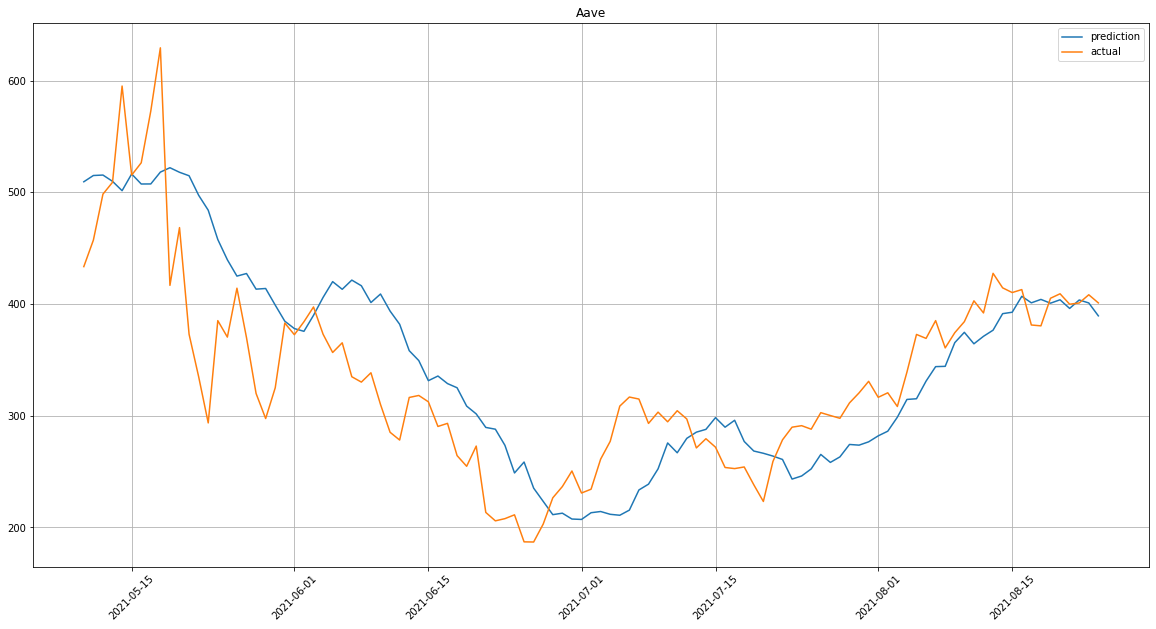

saving weights to weights/Aave.pt
Training on Algorand


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

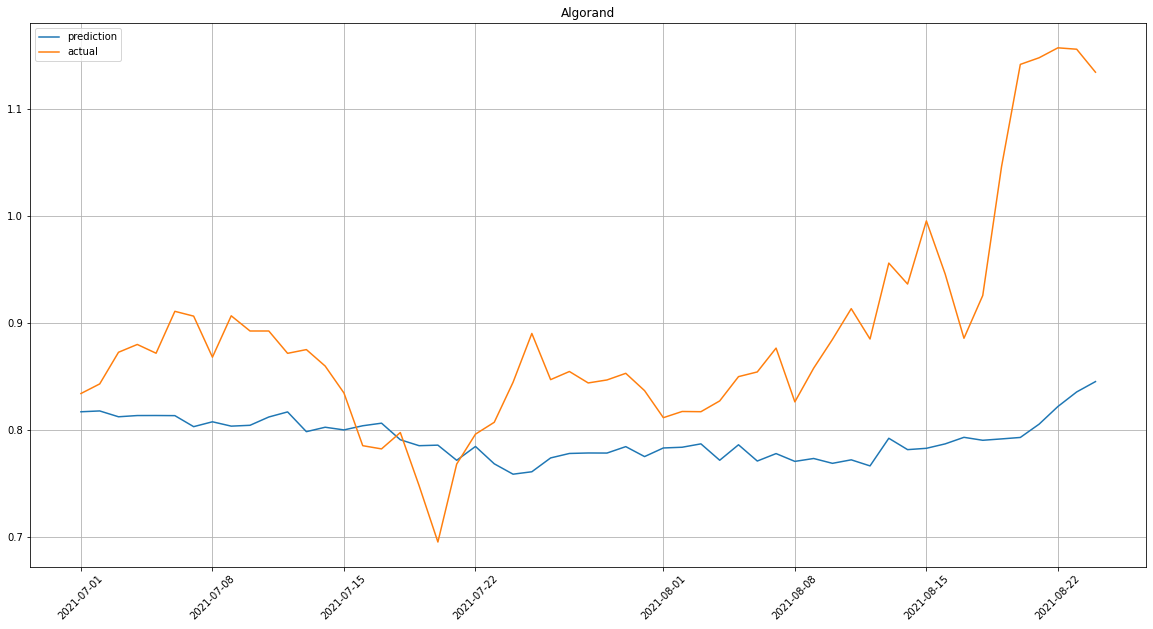

saving weights to weights/Algorand.pt
Training on Avalanche


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

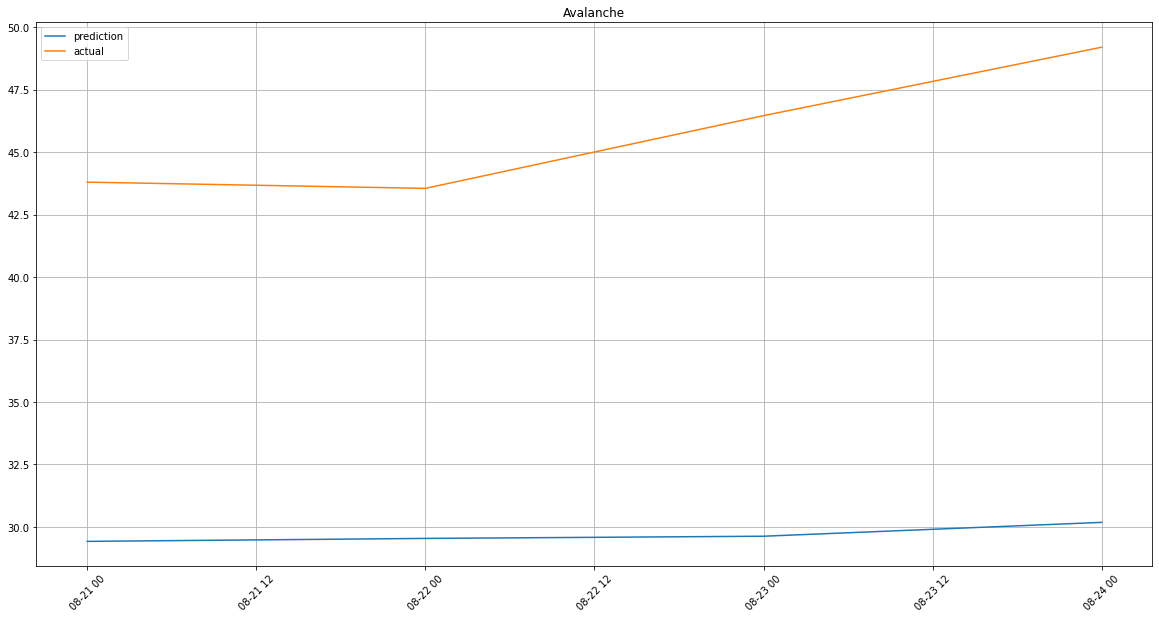

saving weights to weights/Avalanche.pt
Training on Axie_Infinity


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Error occurred while training on Axie_Infinity, skipping...
Training on Binance_Coin


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

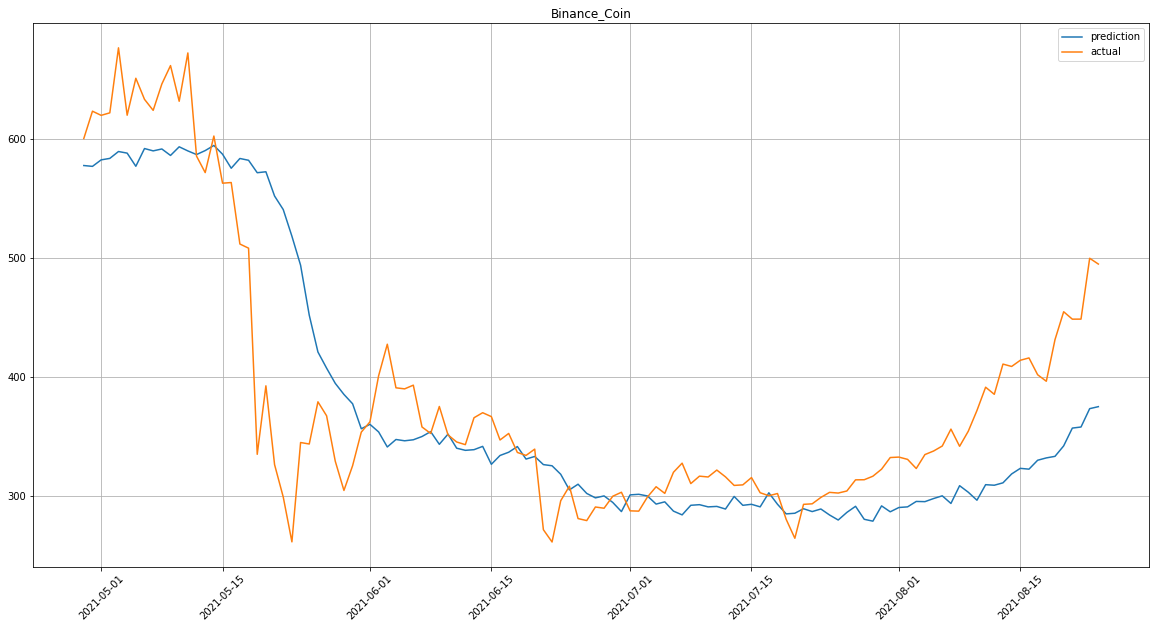

saving weights to weights/Binance_Coin.pt
Training on Binance_USD


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Error occurred while training on Binance_USD, skipping...
Training on BitTorrent


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

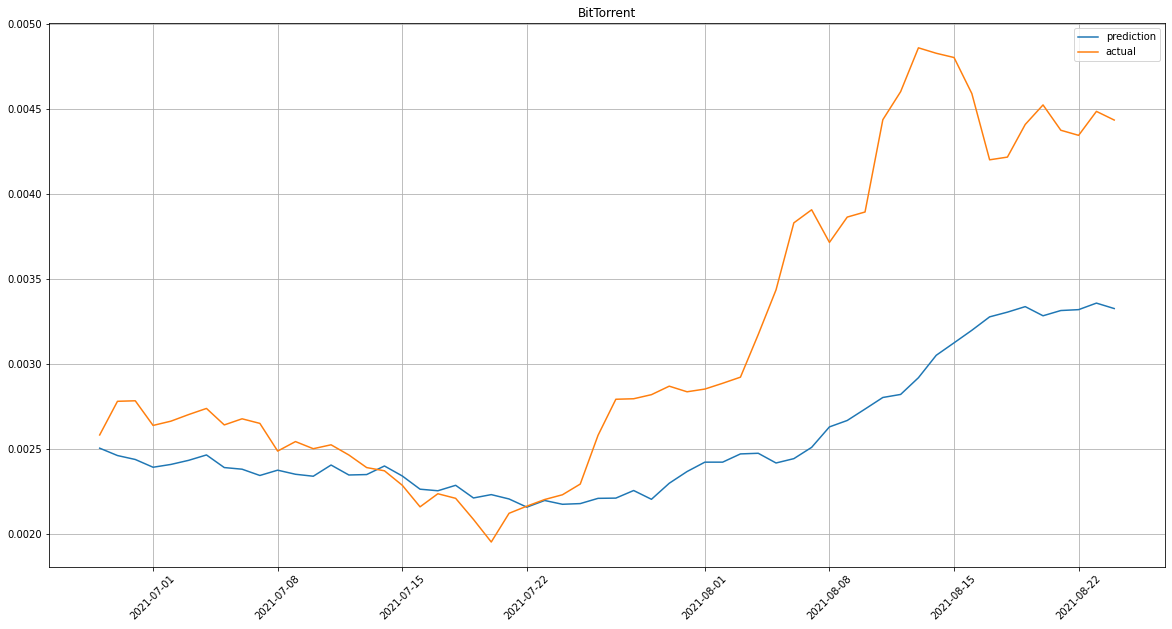

saving weights to weights/BitTorrent.pt
Training on Bitcoin


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

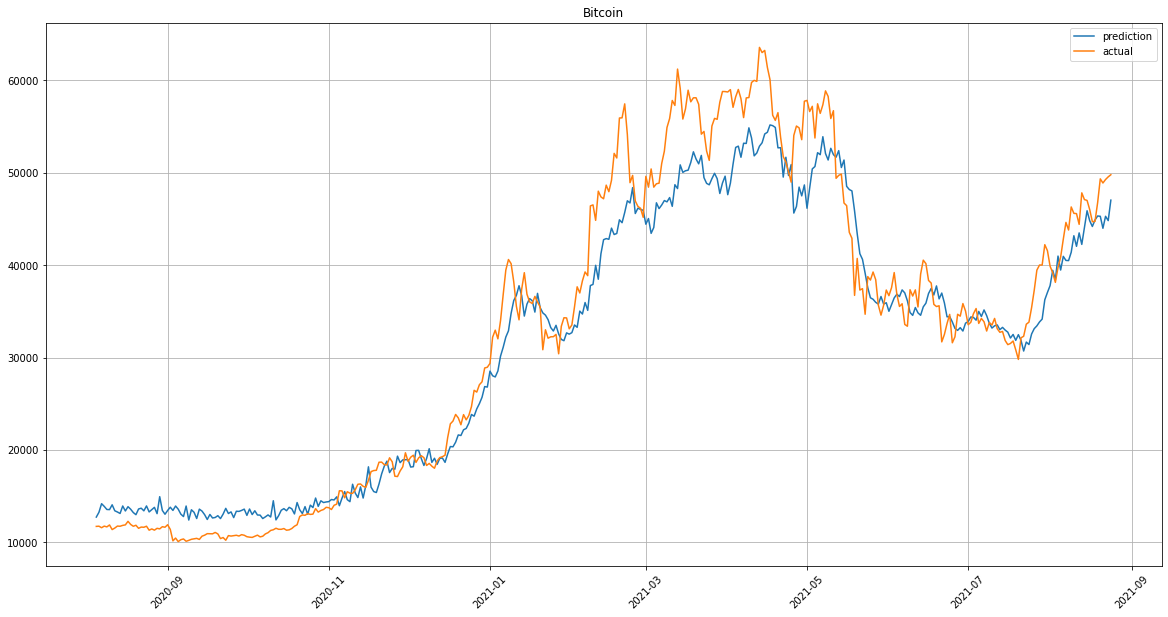

saving weights to weights/Bitcoin.pt
Training on Bitcoin_BEP2


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Error occurred while training on Bitcoin_BEP2, skipping...
Training on Bitcoin_Cash


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

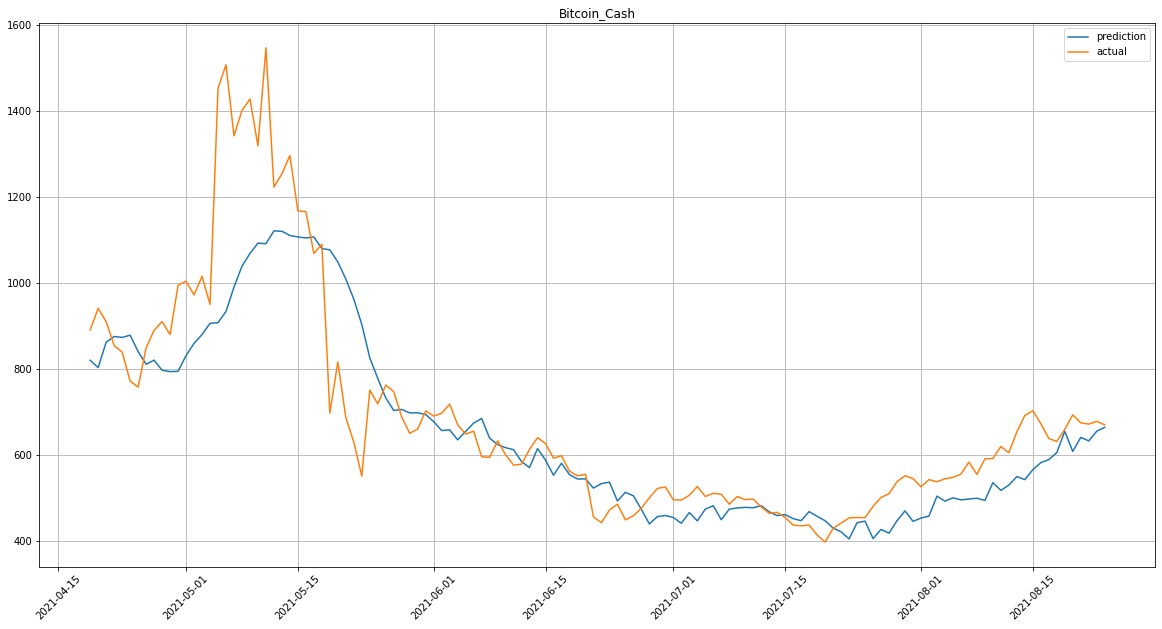

saving weights to weights/Bitcoin_Cash.pt
Training on Bitcoin_SV


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

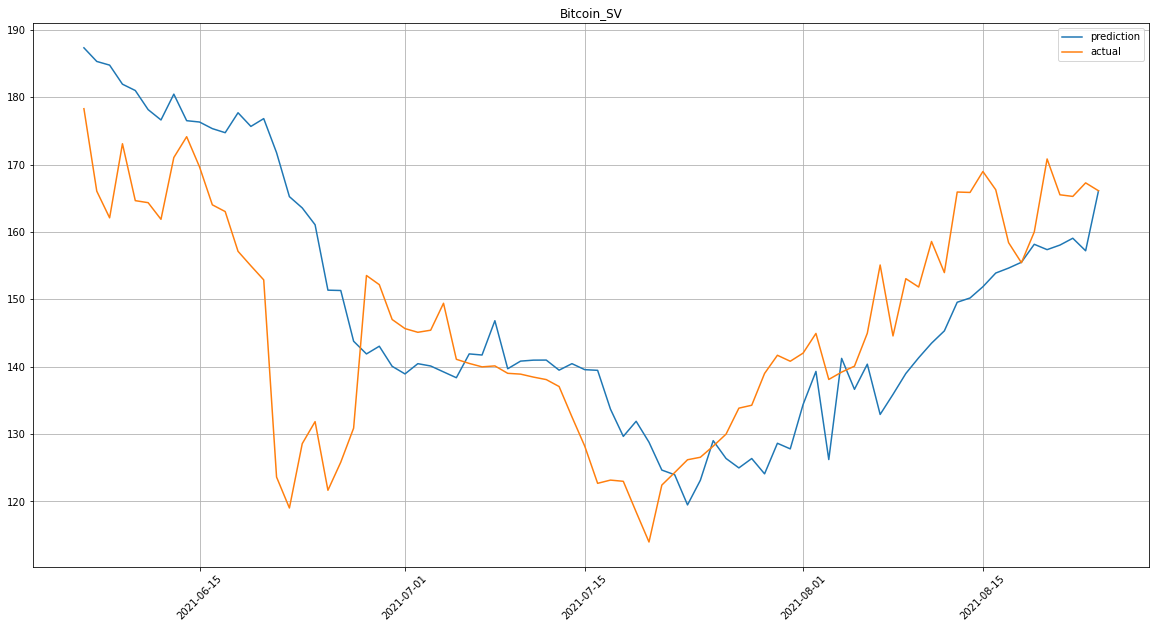

saving weights to weights/Bitcoin_SV.pt
Training on Cardano


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

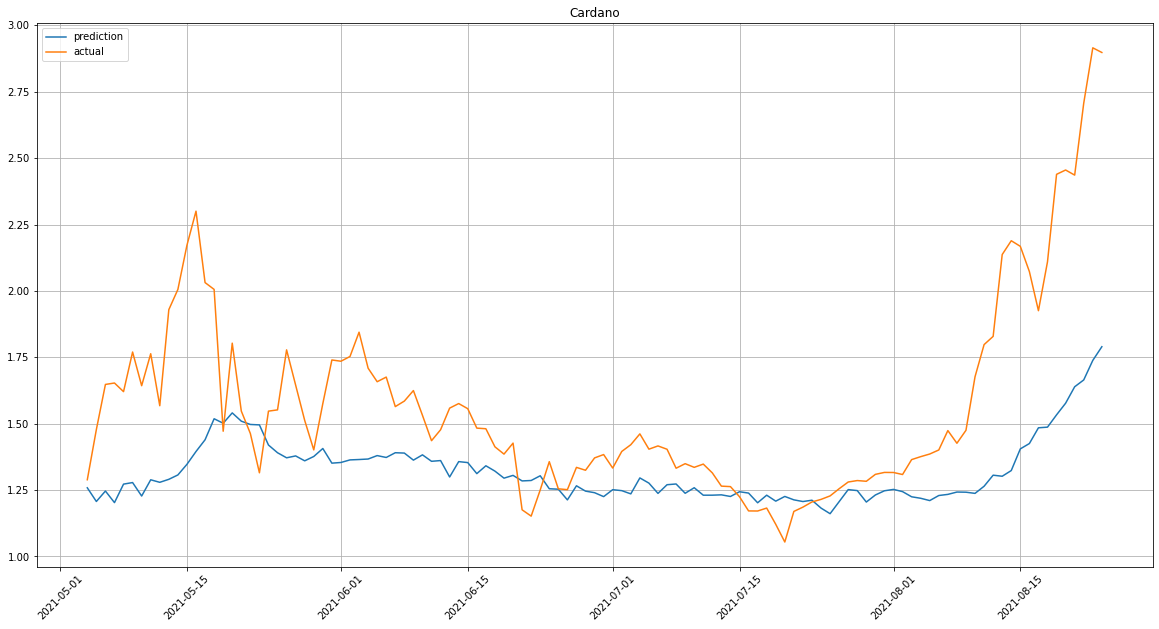

saving weights to weights/Cardano.pt
Training on Chainlink


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

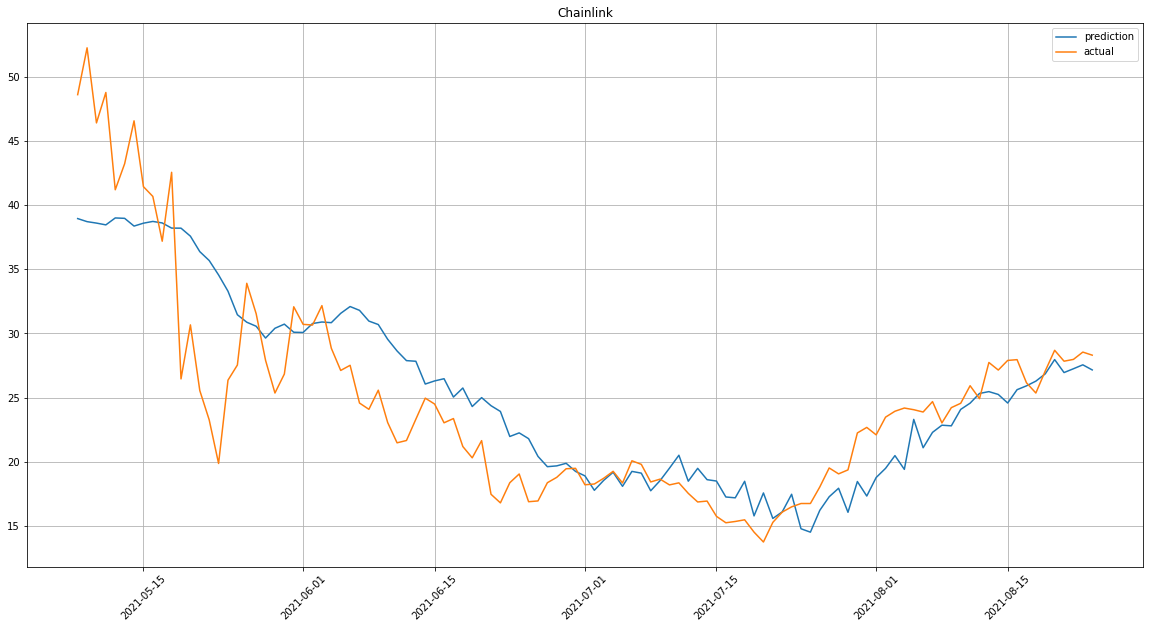

saving weights to weights/Chainlink.pt
Training on Cosmos


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

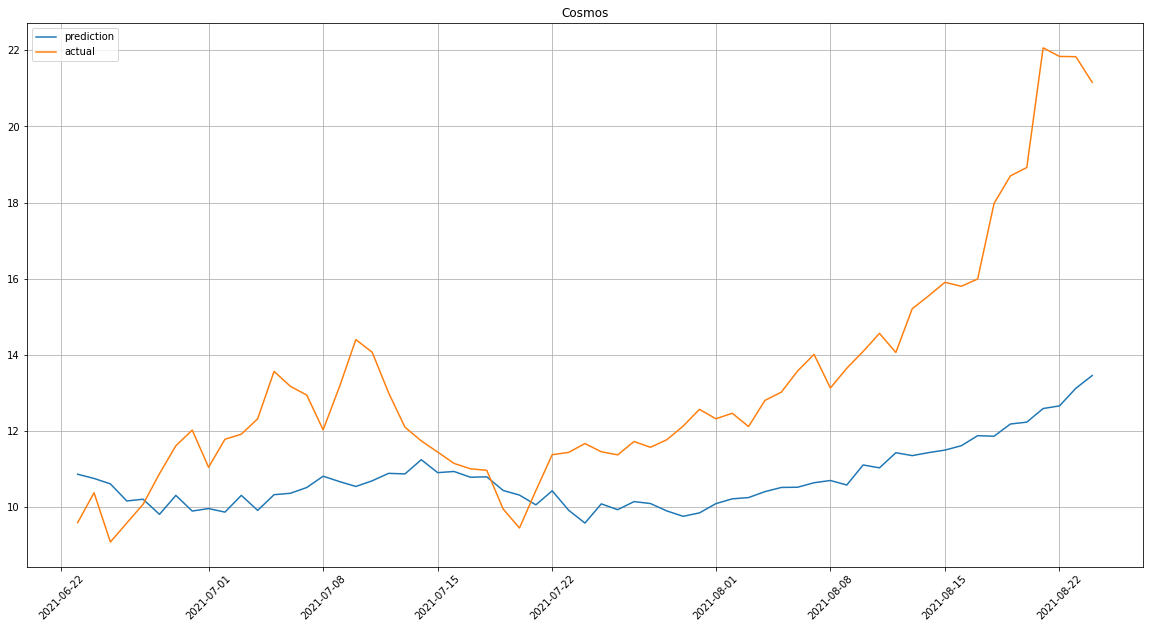

saving weights to weights/Cosmos.pt
Training on Crypto


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

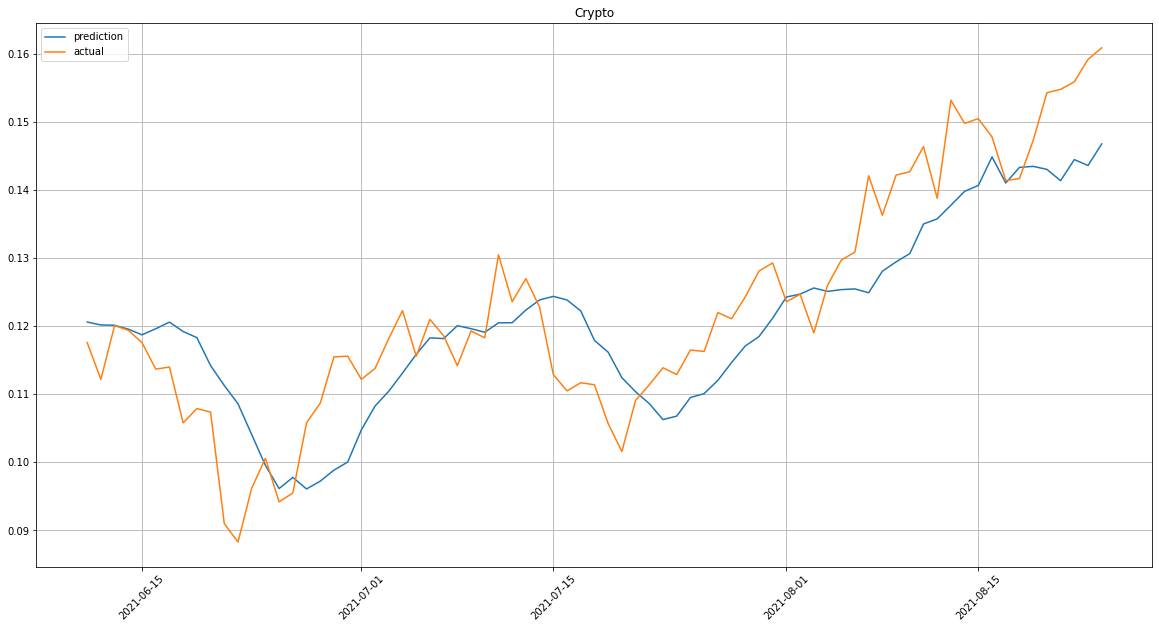

saving weights to weights/Crypto.pt
Training on Dai


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

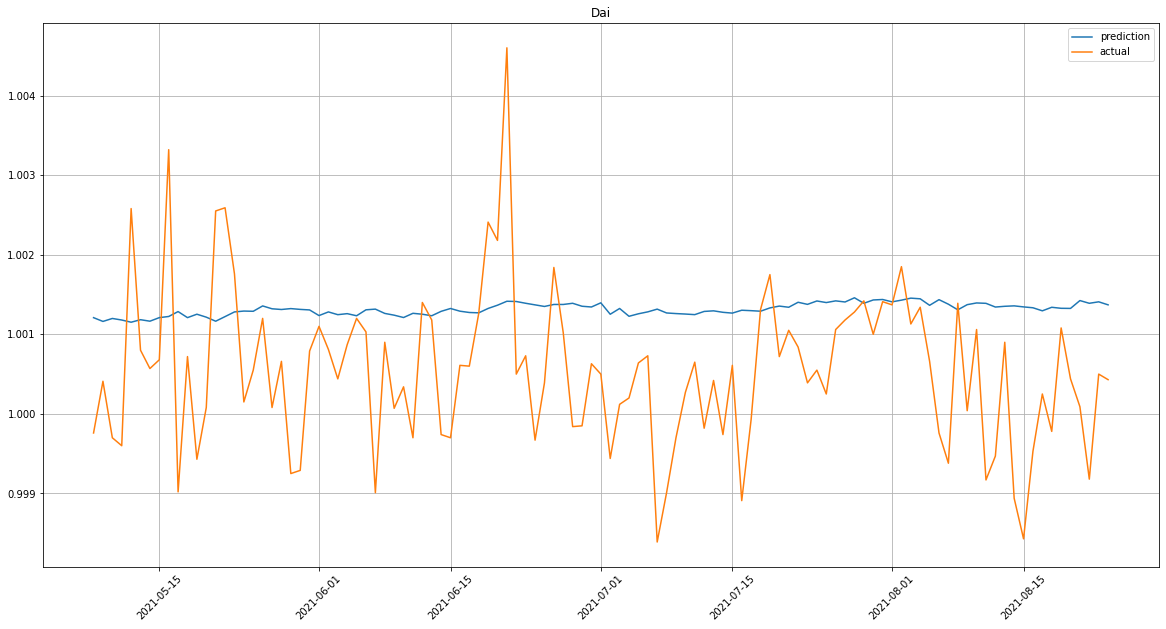

saving weights to weights/Dai.pt
Training on Dash


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

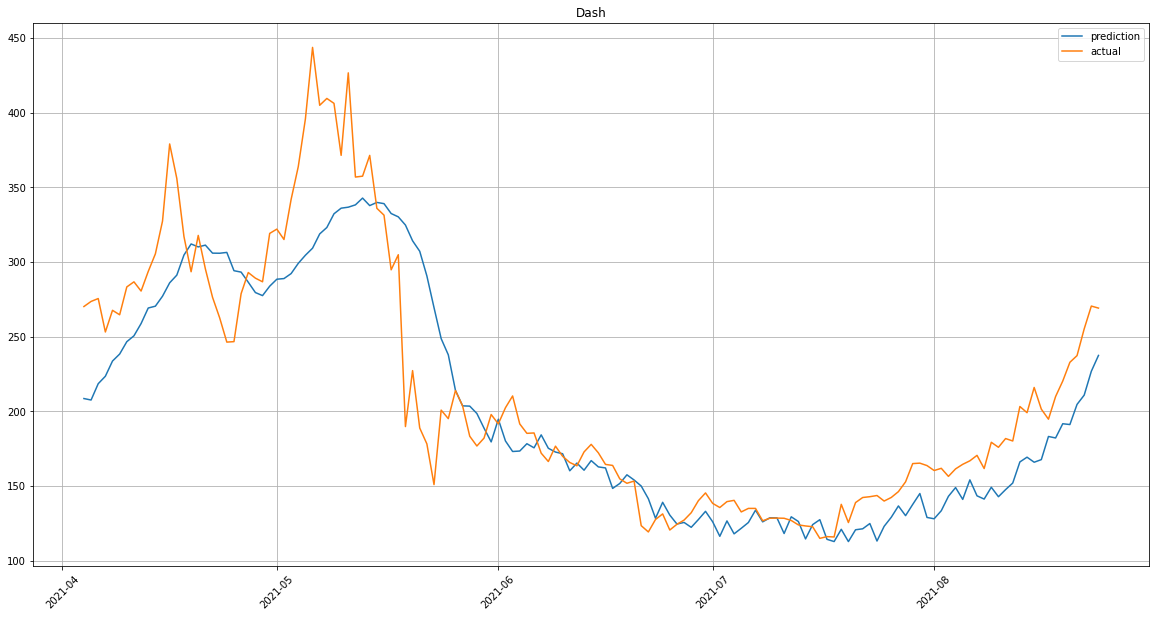

saving weights to weights/Dash.pt
Training on Dogecoin


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

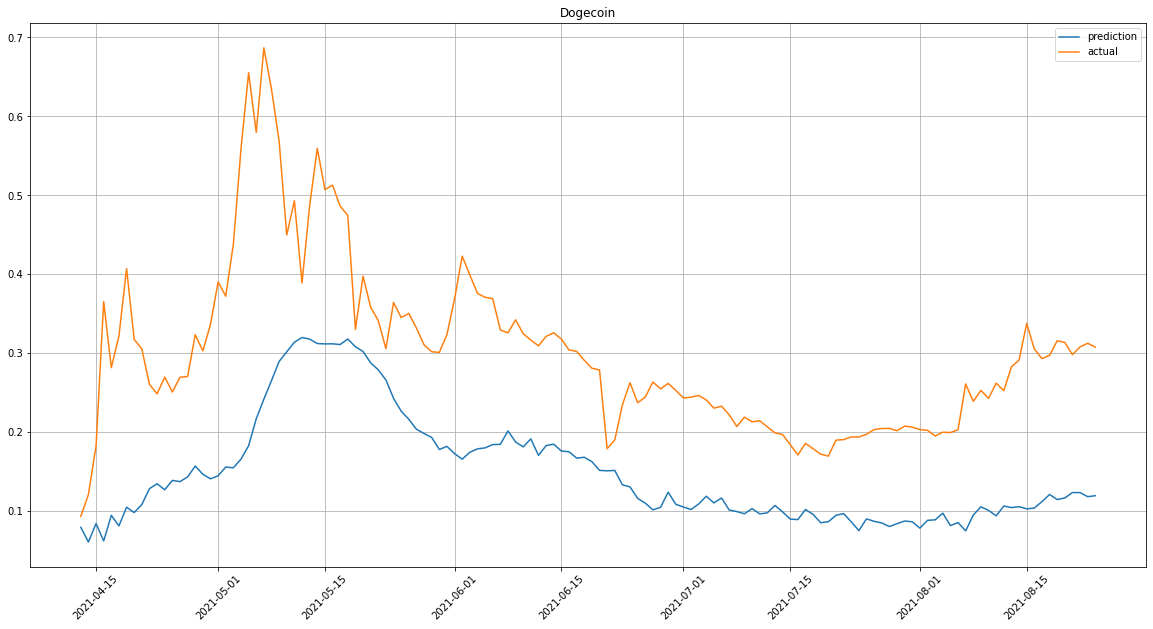

saving weights to weights/Dogecoin.pt
Training on EOS


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

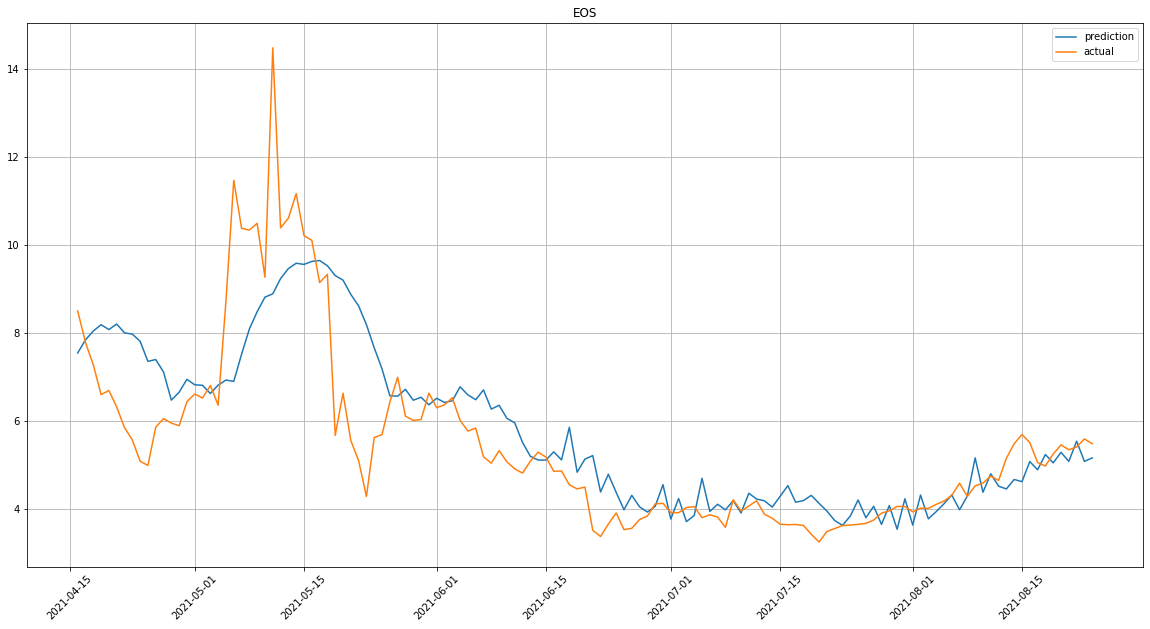

saving weights to weights/EOS.pt
Training on Elrond


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

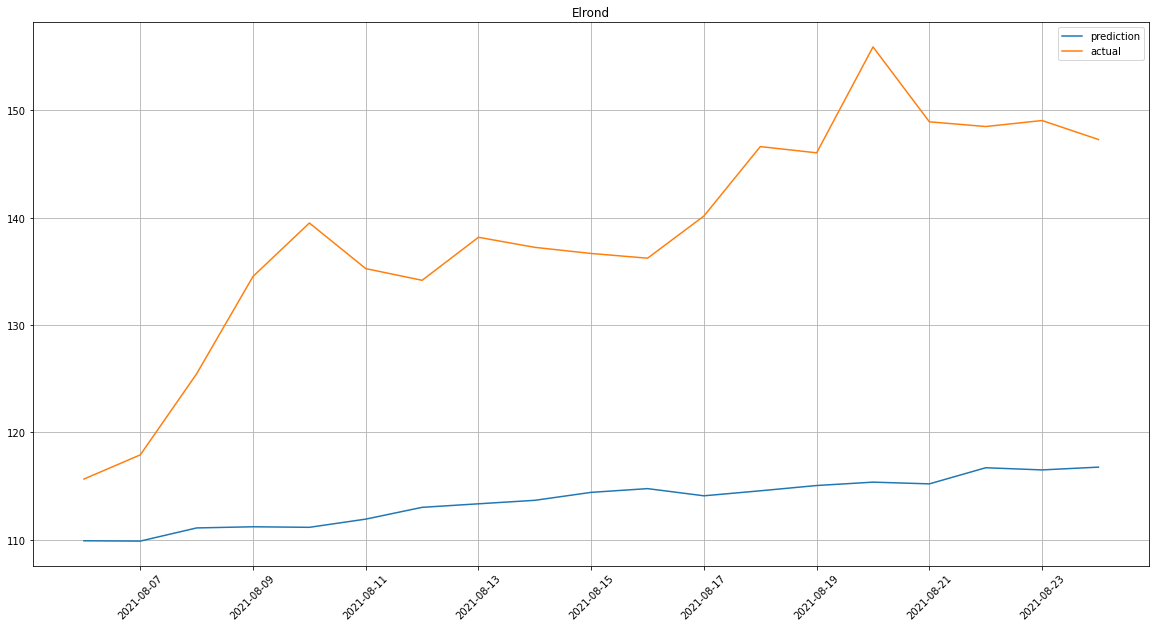

saving weights to weights/Elrond.pt
Training on Ethereum


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

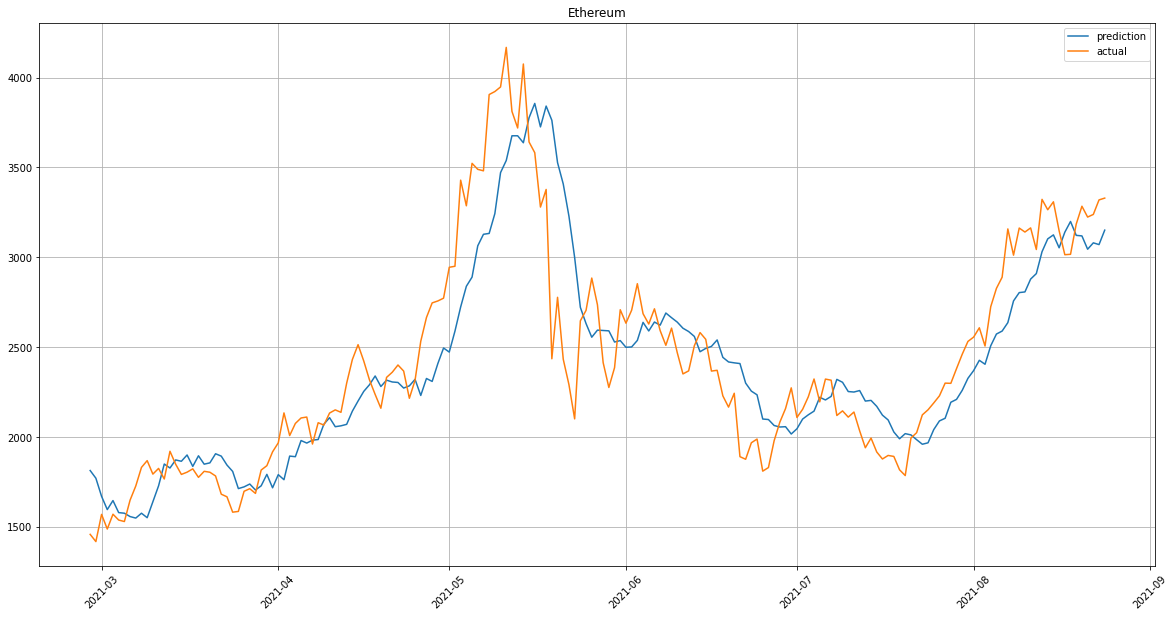

saving weights to weights/Ethereum.pt
Training on FTX_Token


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

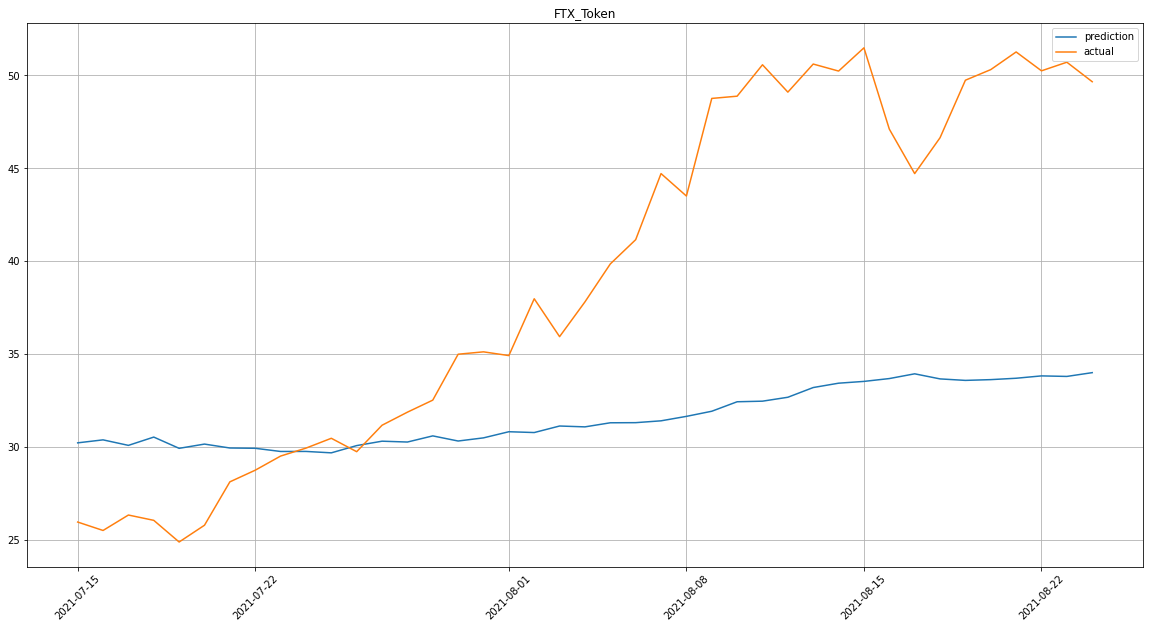

saving weights to weights/FTX_Token.pt
Training on Filecoin


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

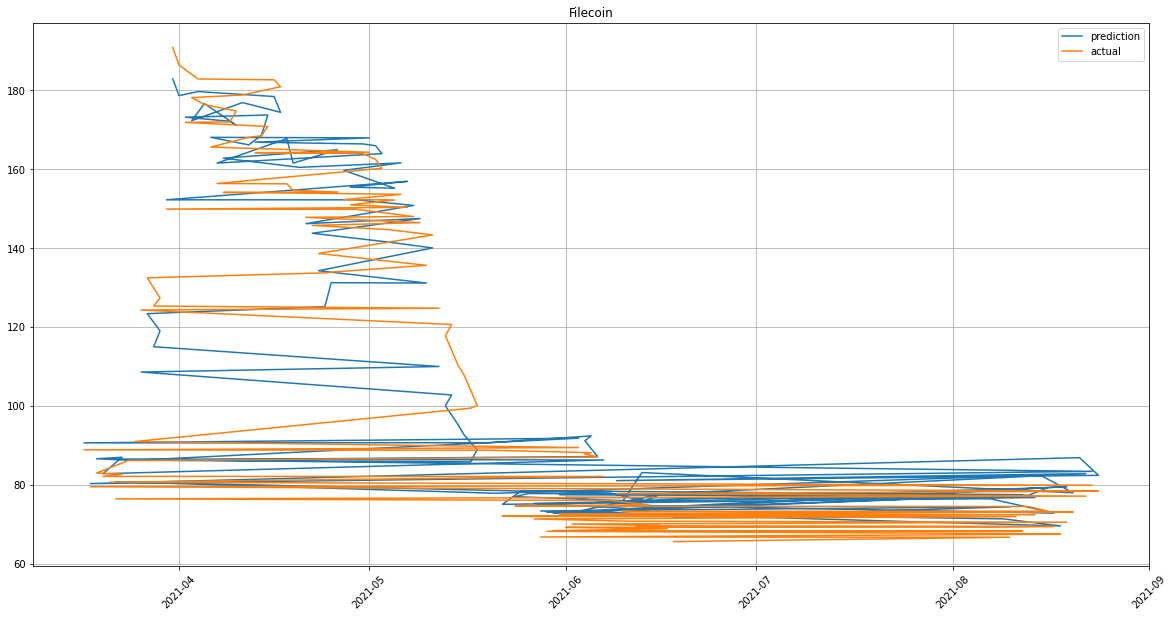

saving weights to weights/Filecoin.pt
Training on GRT


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

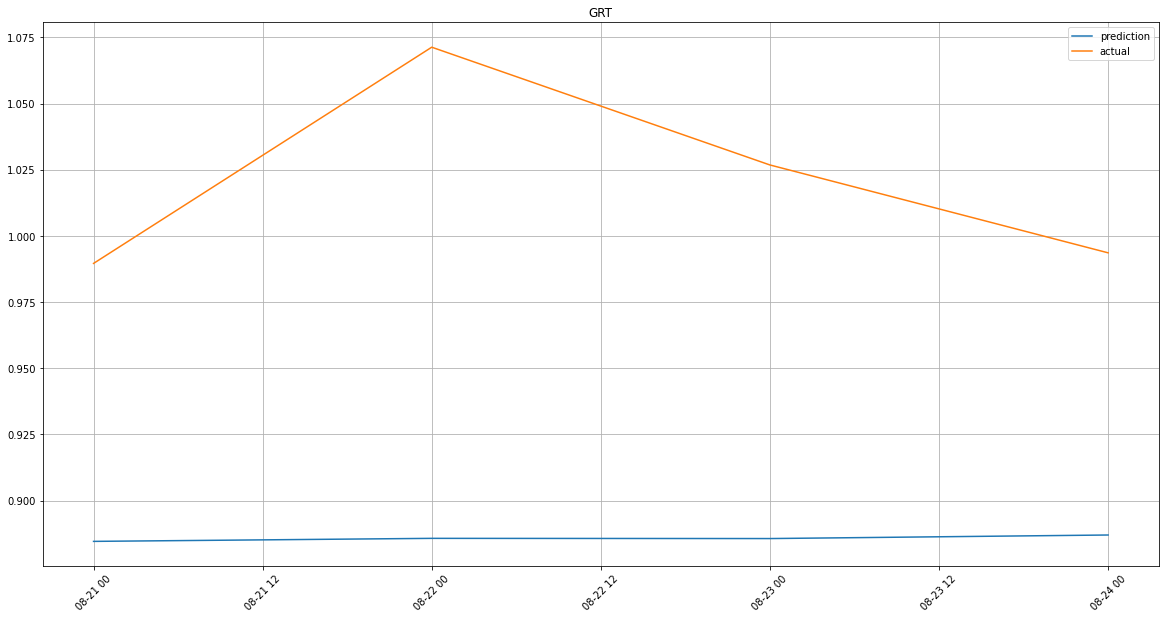

saving weights to weights/GRT.pt
Training on ICP


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Error occurred while training on ICP, skipping...
Training on IOTA


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

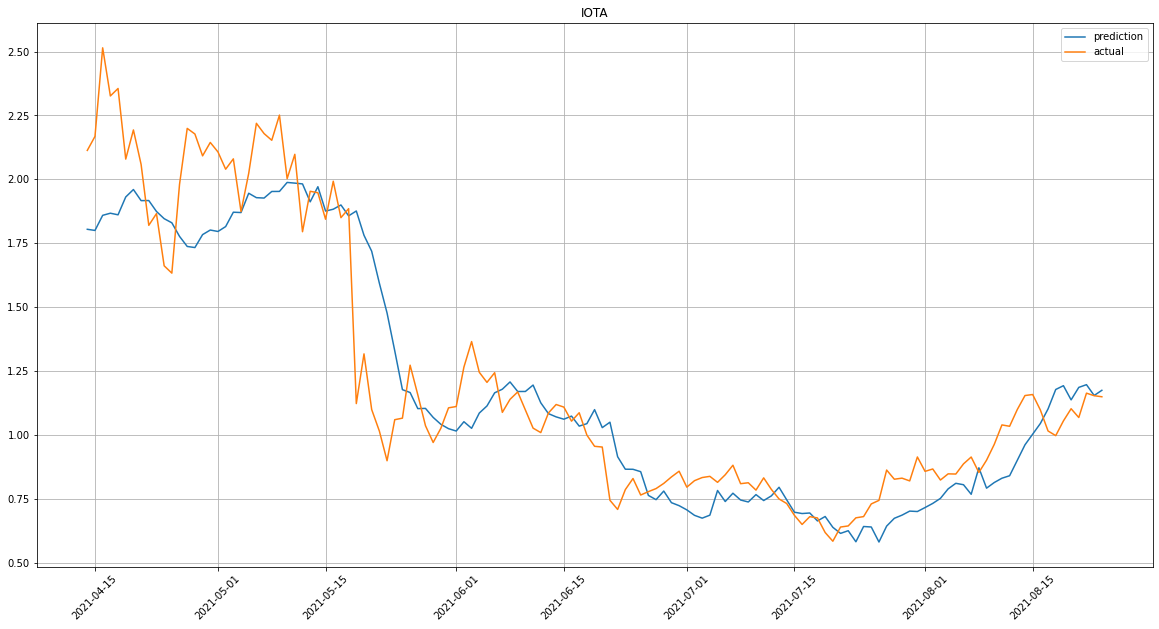

saving weights to weights/IOTA.pt
Training on Klaytn


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Error occurred while training on Klaytn, skipping...
Training on Kusama


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

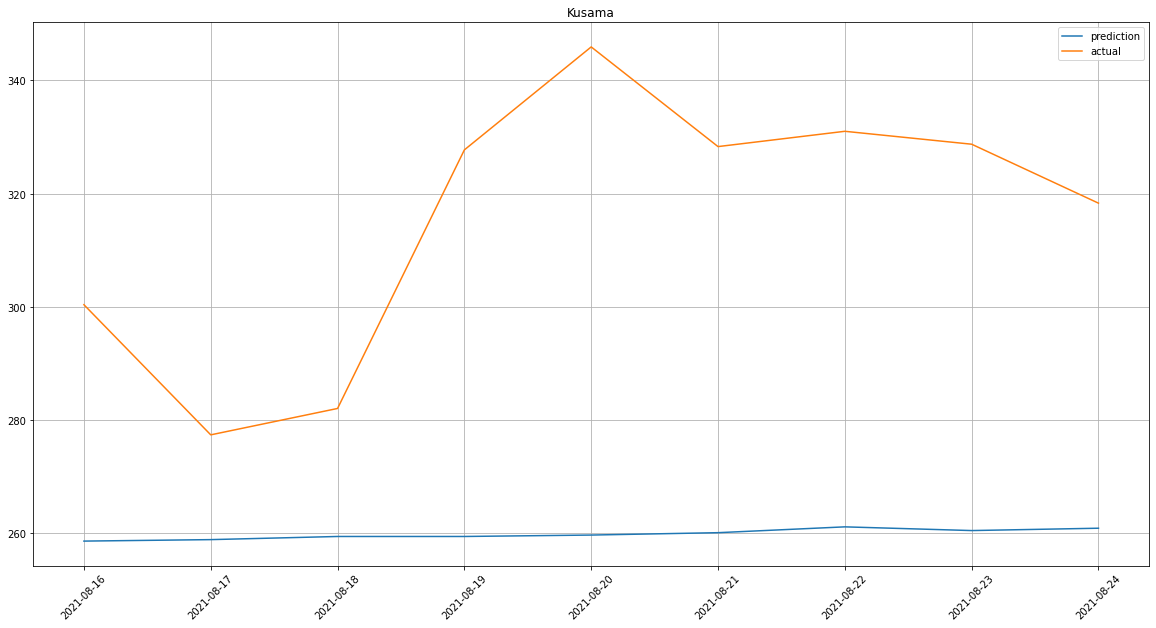

saving weights to weights/Kusama.pt
Training on LEO


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

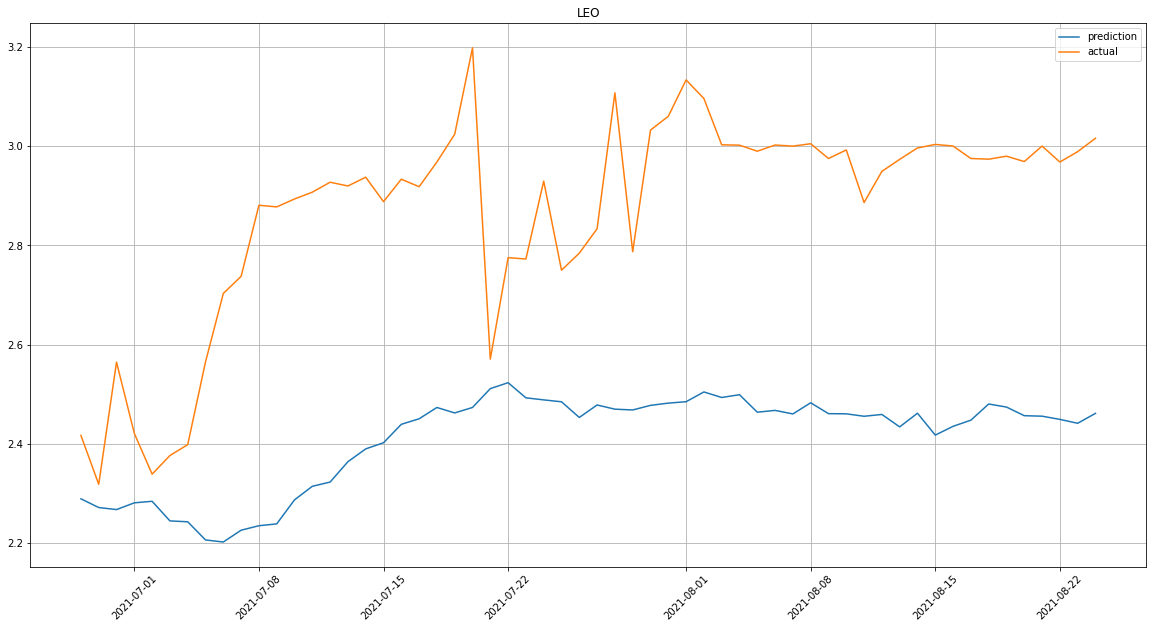

saving weights to weights/LEO.pt
Training on Litecoin


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

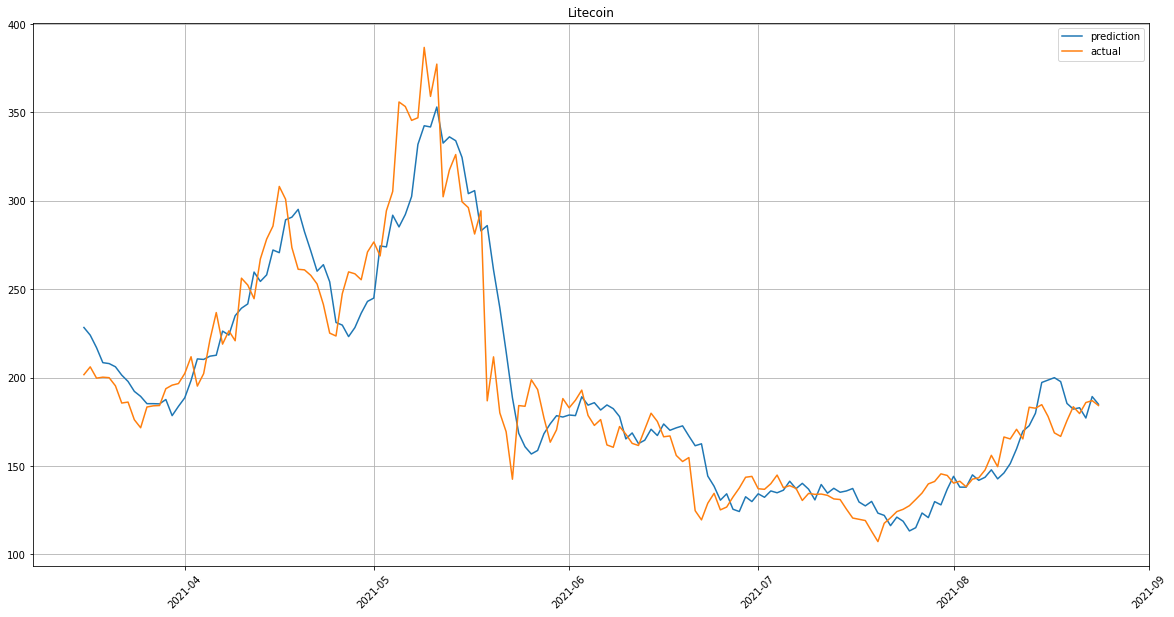

saving weights to weights/Litecoin.pt
Training on Maker


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

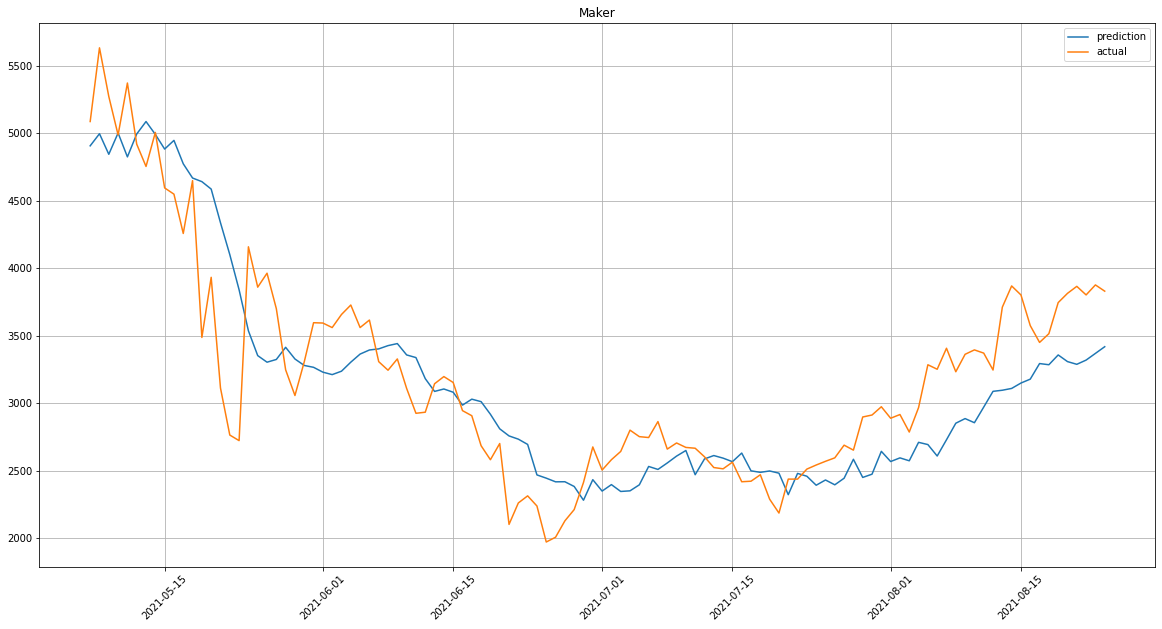

saving weights to weights/Maker.pt
Training on Monero


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

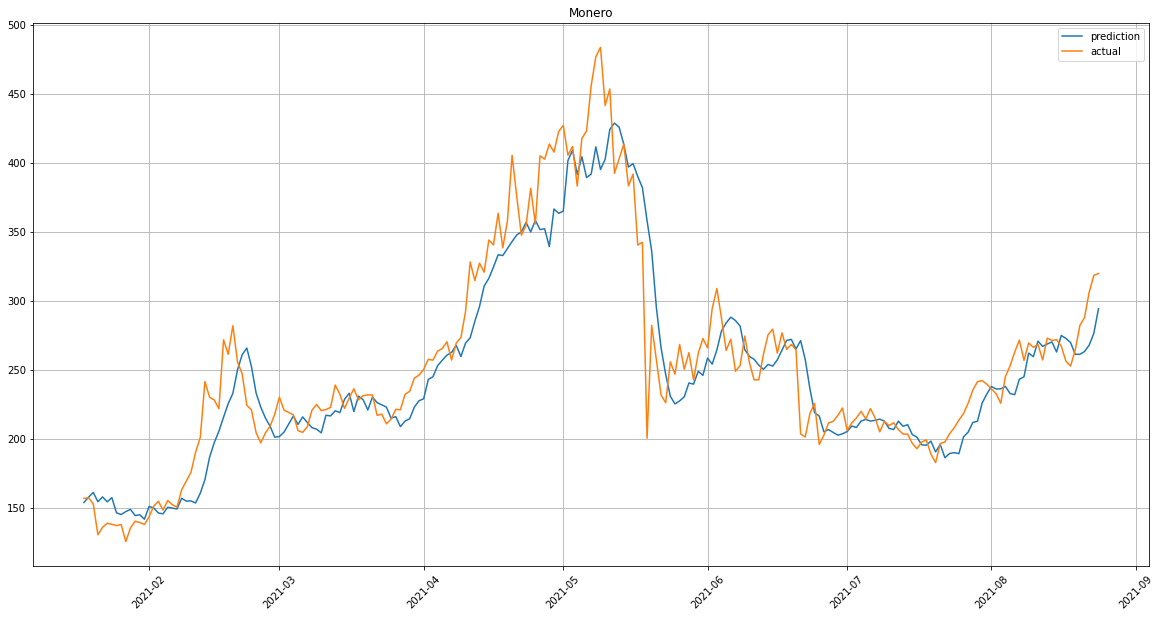

saving weights to weights/Monero.pt
Training on Neo


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

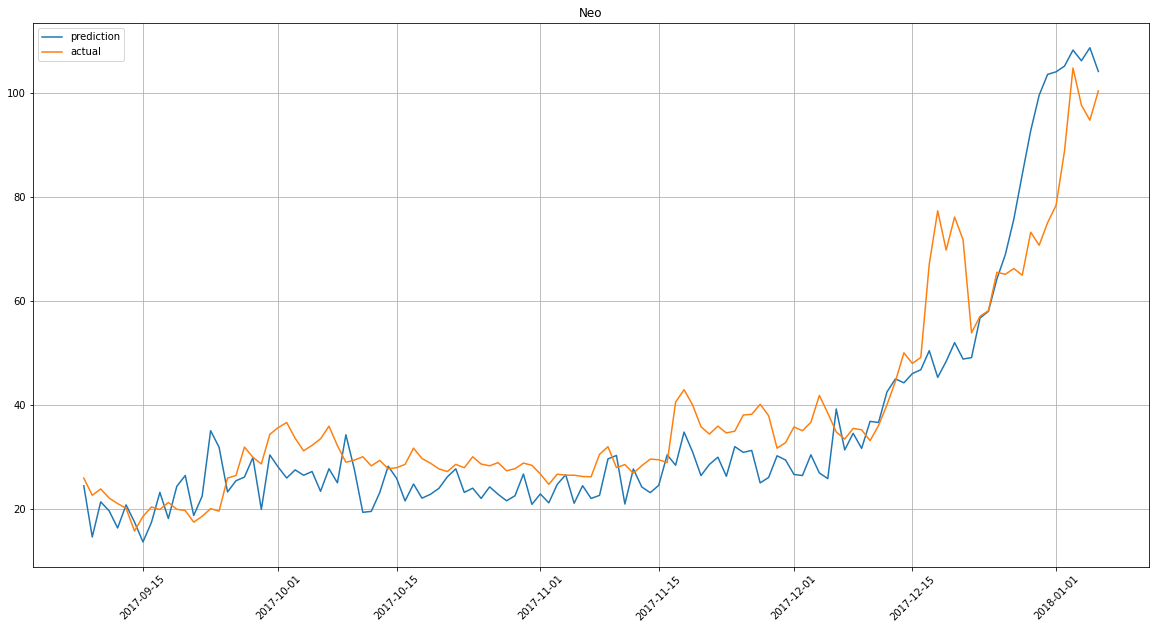

saving weights to weights/Neo.pt
Training on PancakeSwap


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Error occurred while training on PancakeSwap, skipping...
Training on Polkadot


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

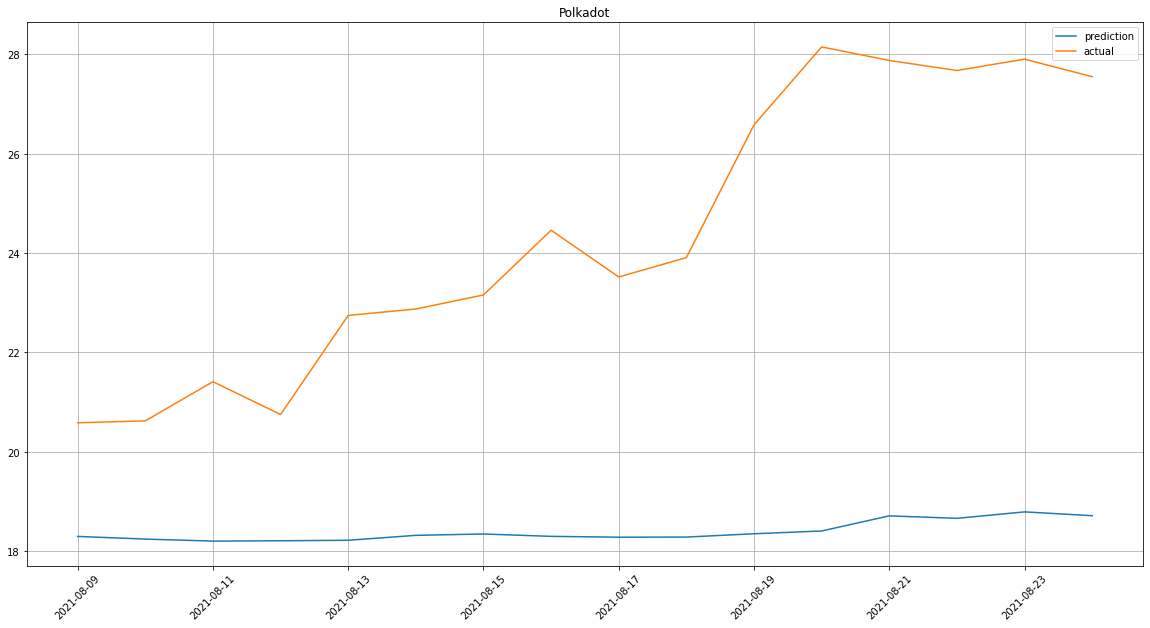

saving weights to weights/Polkadot.pt
Training on Polygon


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

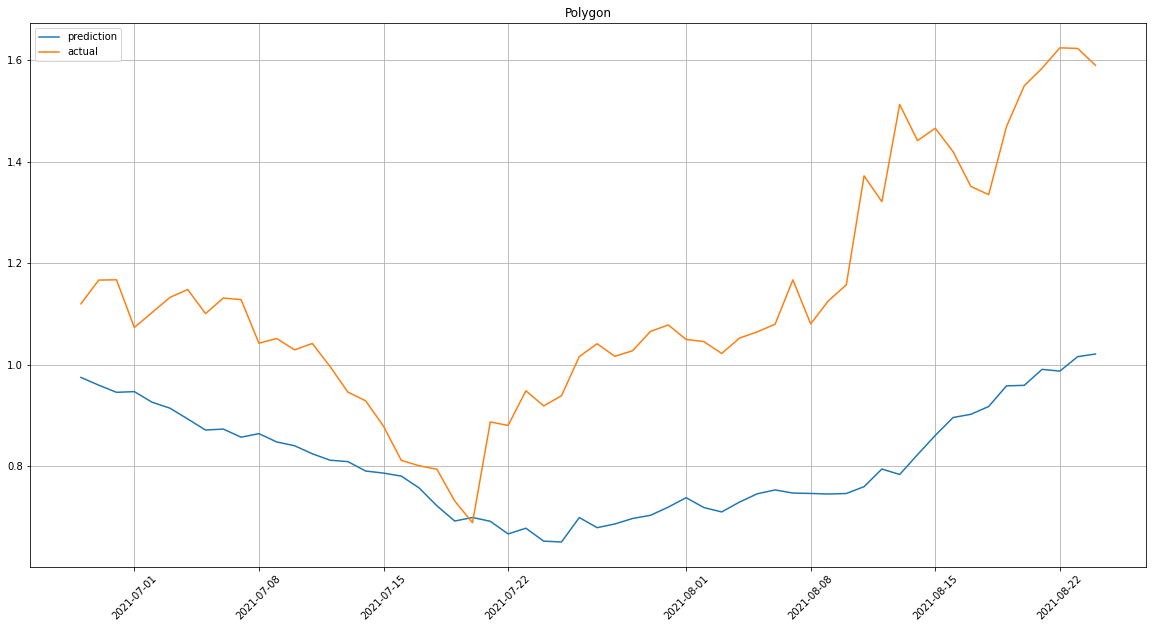

saving weights to weights/Polygon.pt
Training on SHIBA_INU


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Error occurred while training on SHIBA_INU, skipping...
Training on Solana


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

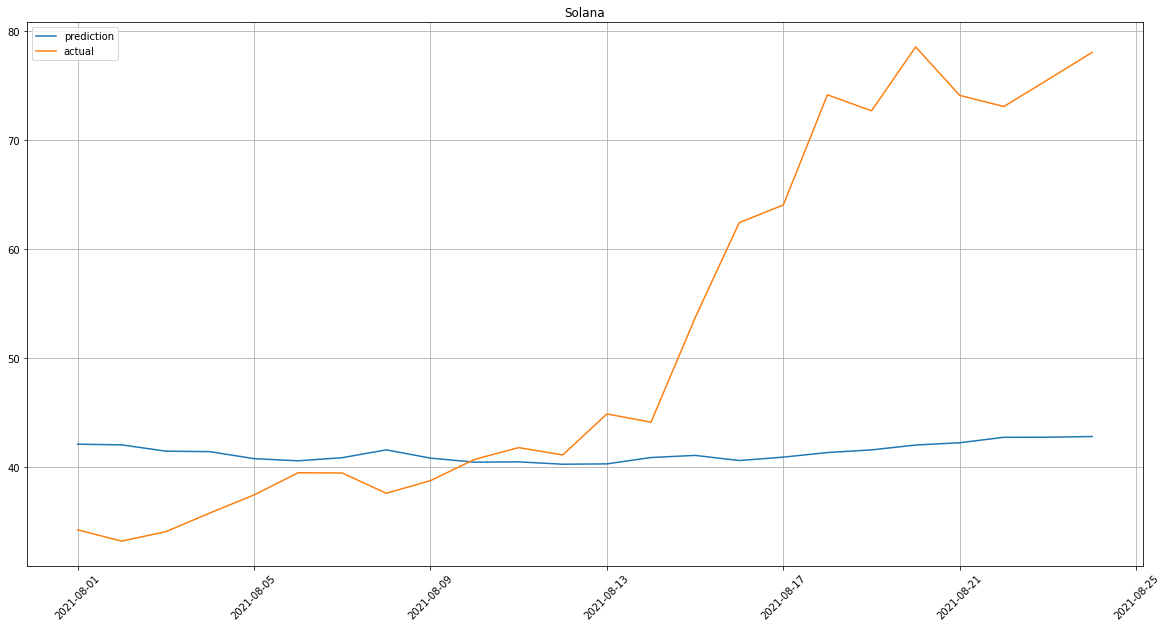

saving weights to weights/Solana.pt
Training on THETA


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

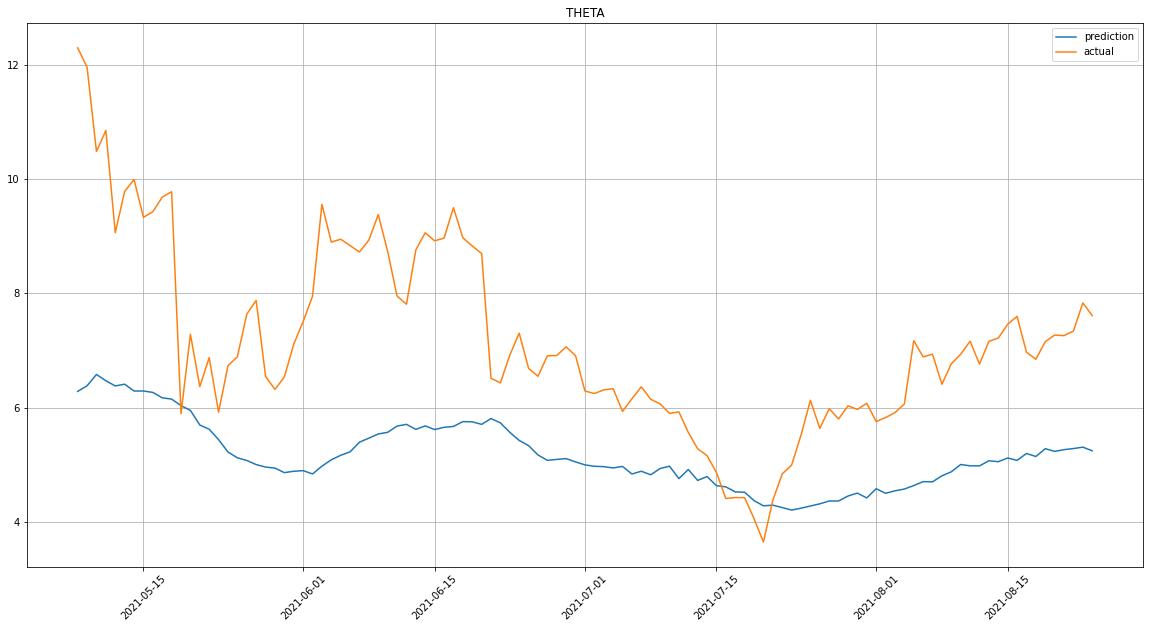

saving weights to weights/THETA.pt
Training on Tezos


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

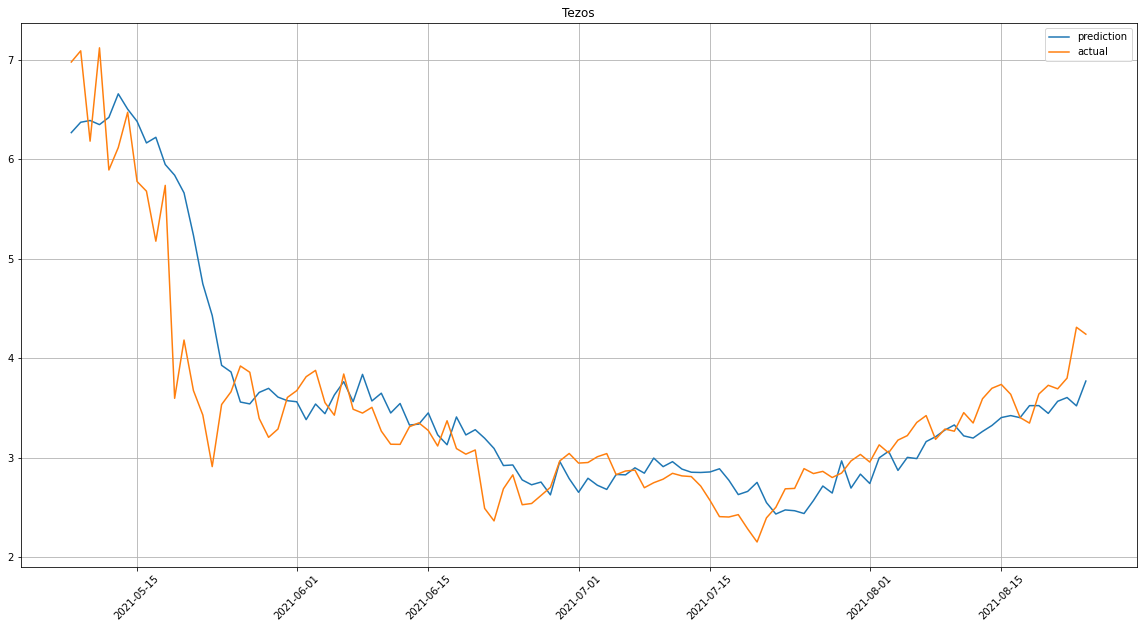

saving weights to weights/Tezos.pt
Training on Tron


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

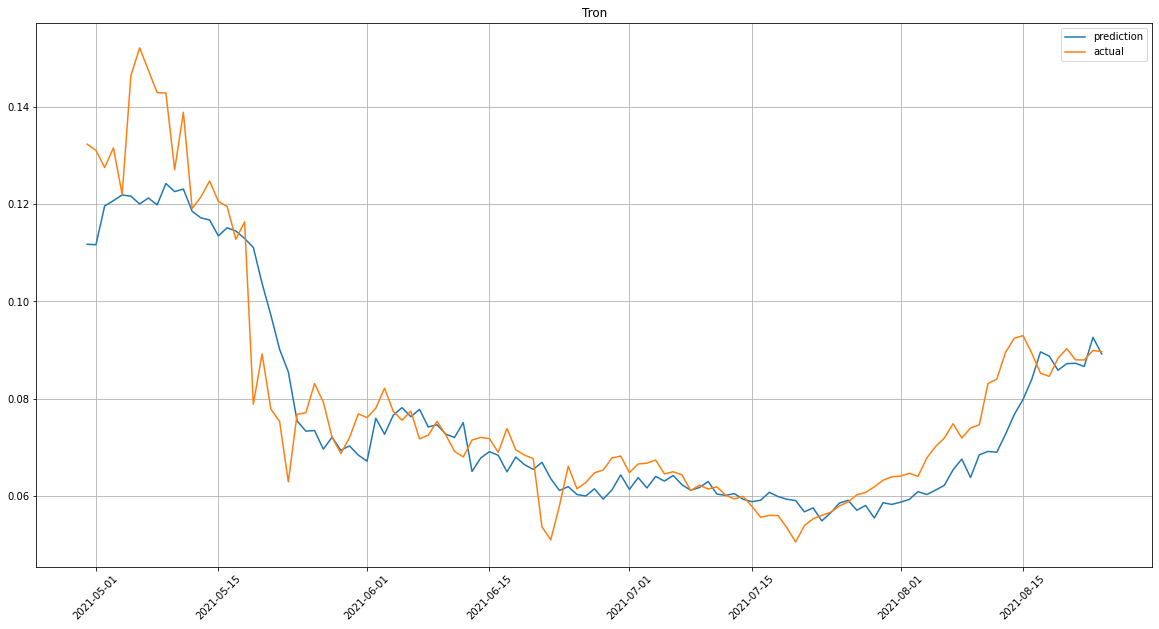

saving weights to weights/Tron.pt
Training on VeChain


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

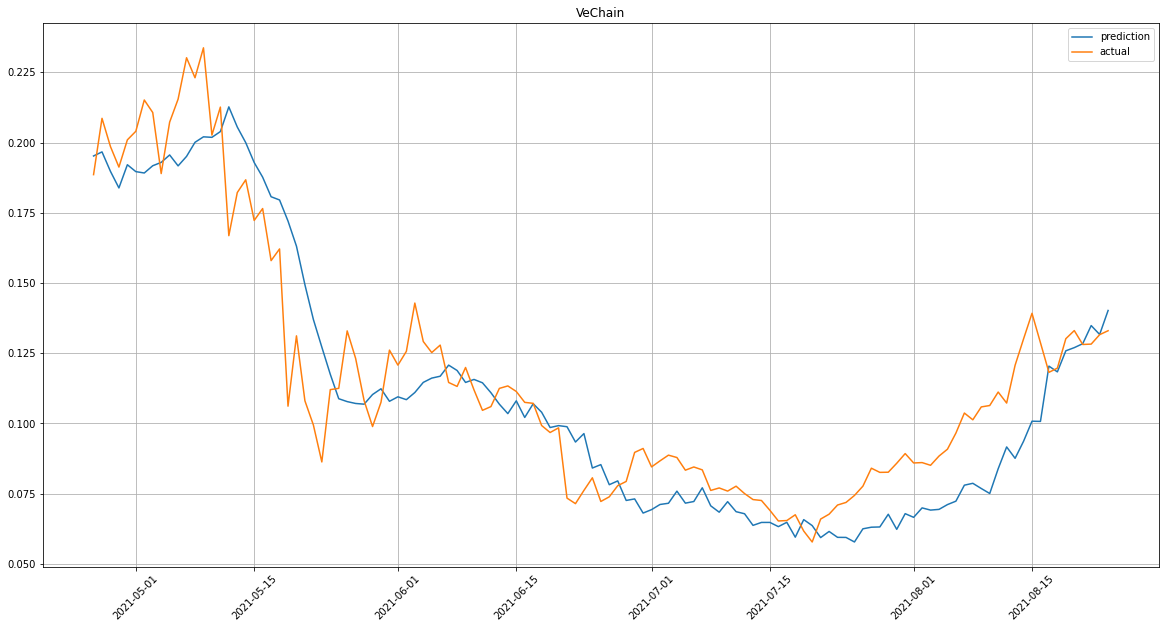

saving weights to weights/VeChain.pt
Training on WBTC


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

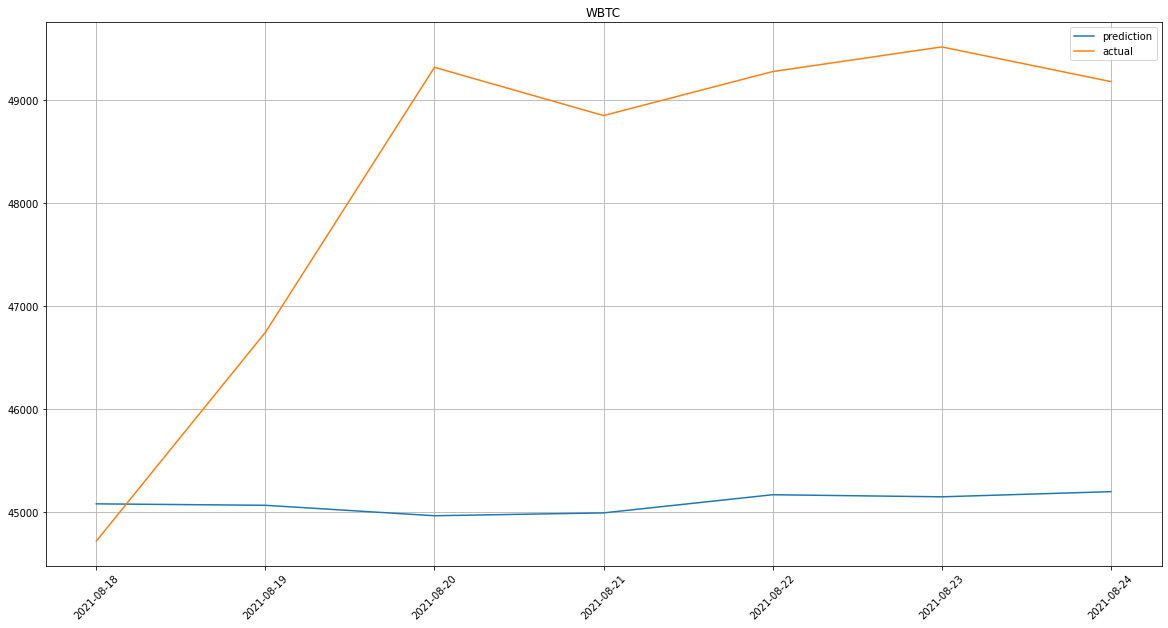

saving weights to weights/WBTC.pt
Training on Waves


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

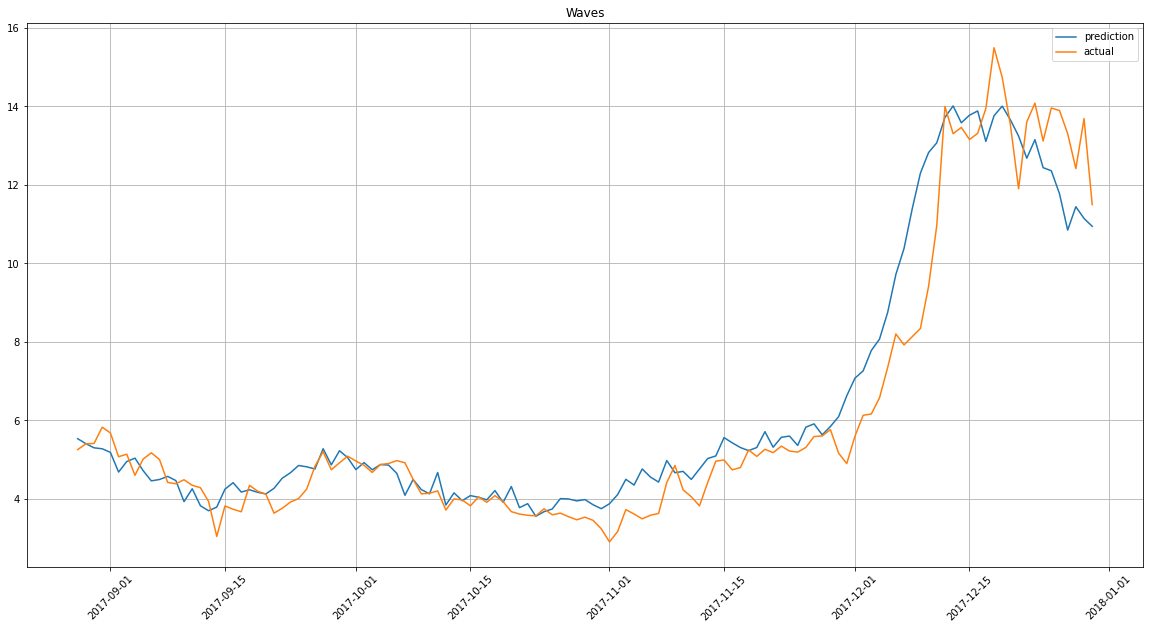

saving weights to weights/Waves.pt
Training on XPR


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

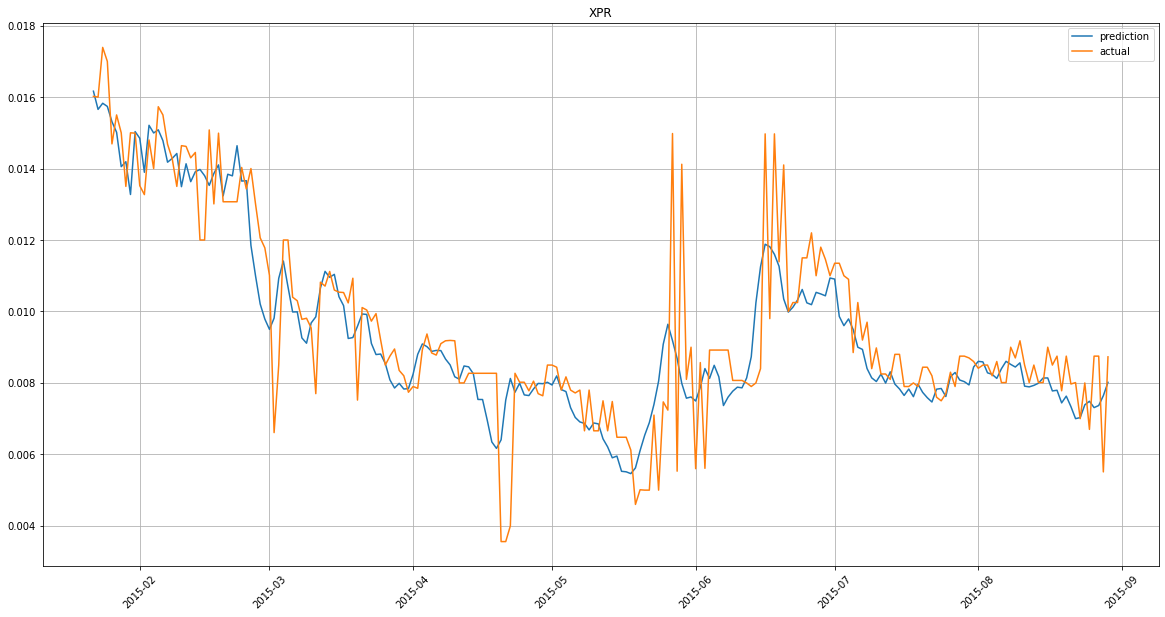

saving weights to weights/XPR.pt


In [7]:
train_all_models()

In [8]:
returns_df = [df for df in returns if len(df) == 62]
# for i in range(len(returns_df)):
#     returns_df[i].
# returns_df.index = returns[0]['date'].values
# for i in range(len(returns)):
#     if len(returns[i]) == 62:
#         returns_df = pd.concat([returns_df, returns[i]], axis=1, ignore_index=True)
        
good_returns = pd.concat(returns_df, axis=1)
good_returns

,Aave,date,Binance_Coin,date,Bitcoin,date,Bitcoin_Cash,date,Cardano,date,...,Monero,date,THETA,date,Tezos,date,Tron,date,VeChain,date
22,378.028752,2021-06-01,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
23,375.579216,2021-06-02,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
24,389.896634,2021-06-03,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,4.902078,2021-06-01,3.561566,2021-06-01,NaN,NaT,NaN,NaT
25,405.951444,2021-06-04,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,4.844539,2021-06-02,3.381785,2021-06-02,NaN,NaT,NaN,NaT
26,420.063092,2021-06-05,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,4.979222,2021-06-03,3.538721,2021-06-03,NaN,NaT,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,NaN,NaT,NaN,NaT,33845.132163,2021-07-28,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
358,NaN,NaT,NaN,NaT,34154.585769,2021-07-29,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
359,NaN,NaT,NaN,NaT,36245.181368,2021-07-30,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
360,NaN,NaT,NaN,NaT,37037.834358,2021-07-31,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT


In [9]:
# returns_df[0].drop('date', axis=1, inplace=True)
for i in range(len(returns_df)):
    try:
        returns_df[i].set_index('date', inplace=True)
    except KeyError as e:
        print('already done')

In [10]:
out = pd.concat(returns_df, axis=1)
out

,Aave,Binance_Coin,Bitcoin,Bitcoin_Cash,Cardano,Chainlink,Dai,Dash,Dogecoin,EOS,Ethereum,IOTA,Litecoin,Maker,Monero,THETA,Tezos,Tron,VeChain
date,,,,,,,,,,,,,,,,,,,
2021-06-01,378.028752,360.293193,34999.873076,678.198707,1.353985,30.078788,1.001235,194.640163,0.173081,6.520924,2499.516920,1.014856,178.870236,3230.699464,258.466199,4.902078,3.561566,0.067135,0.109490
2021-06-02,375.579216,353.911649,35734.578783,657.400532,1.363686,30.776879,1.001281,180.079808,0.166102,6.424702,2501.464944,1.051273,178.536870,3212.436039,254.163776,4.844539,3.381785,0.075963,0.108471
2021-06-03,389.896634,341.275934,36446.782619,659.090423,1.365136,30.894211,1.001247,173.029060,0.174812,6.462182,2537.858103,1.025453,189.186289,3237.726177,264.419469,4.979222,3.538721,0.072682,0.111014
2021-06-04,405.951444,347.562876,36844.445564,635.788069,1.366975,30.841644,1.001260,173.338827,0.179139,6.779752,2638.221623,1.085118,184.457711,3304.620547,278.289025,5.092228,3.441920,0.076594,0.114621
2021-06-05,420.063092,346.474120,36591.497399,655.459901,1.379894,31.569086,1.001233,178.238256,0.180377,6.597064,2590.451646,1.112954,185.848499,3364.613430,283.981733,5.170164,3.629301,0.078145,0.116145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-28,263.169589,280.535536,33845.132163,418.984990,1.248114,17.939231,1.001459,130.066786,0.080794,3.659217,2193.811484,0.673266,120.831183,2585.027802,211.887936,4.372358,2.644412,0.058025,0.063146
2021-07-29,274.291587,278.960194,34154.585769,447.930216,1.205003,16.064845,1.001390,137.585799,0.084416,4.086400,2209.802769,0.685630,129.877001,2450.620583,212.764587,4.458185,2.967568,0.055433,0.067673
2021-07-30,273.675379,291.797065,36245.181368,470.748132,1.231634,18.463508,1.001432,144.882556,0.087753,3.548798,2260.238452,0.701437,128.049352,2474.662397,225.913219,4.509299,2.694386,0.058583,0.062292


In [11]:
out.to_csv('lstm_predictions.csv')